In [157]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense, Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras import optimizers

In [24]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

## Loading the data

In [25]:
df = pd.read_csv("data/creditcard.csv")

In [26]:
df.shape

(284807, 31)

In [27]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [28]:
df.isnull().values.any()

False

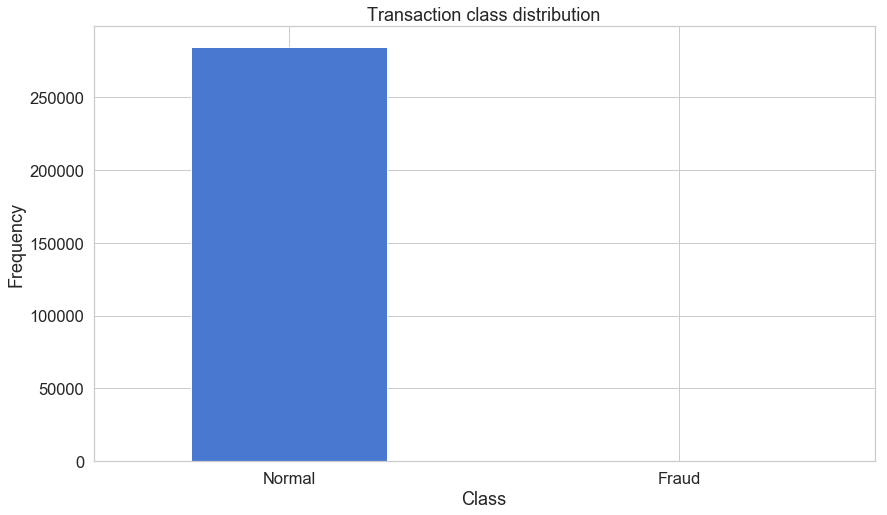

In [29]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [30]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [31]:
frauds.shape

(492, 31)

In [32]:
normal.shape

(284315, 31)

In [33]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [40]:
# frauds.Amount

In [34]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

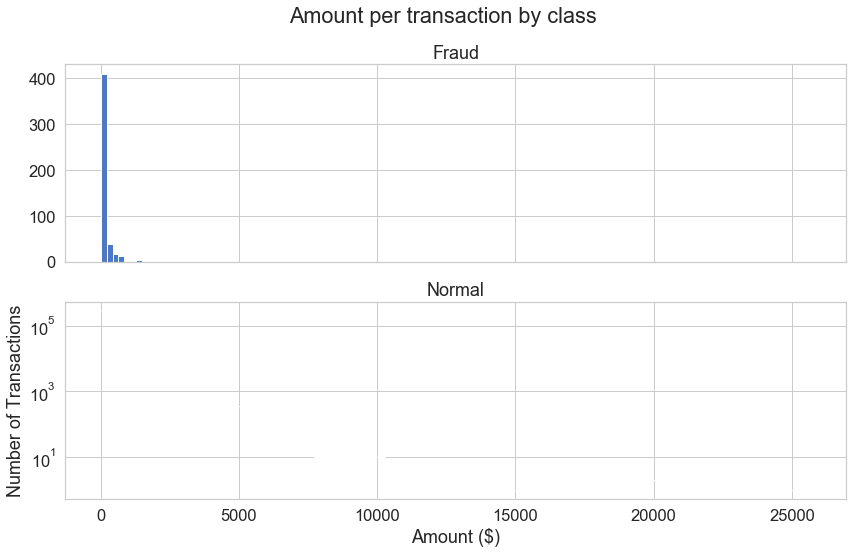

In [47]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 10

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
# plt.xlim((0, 20000))
plt.yscale('log')
plt.show()

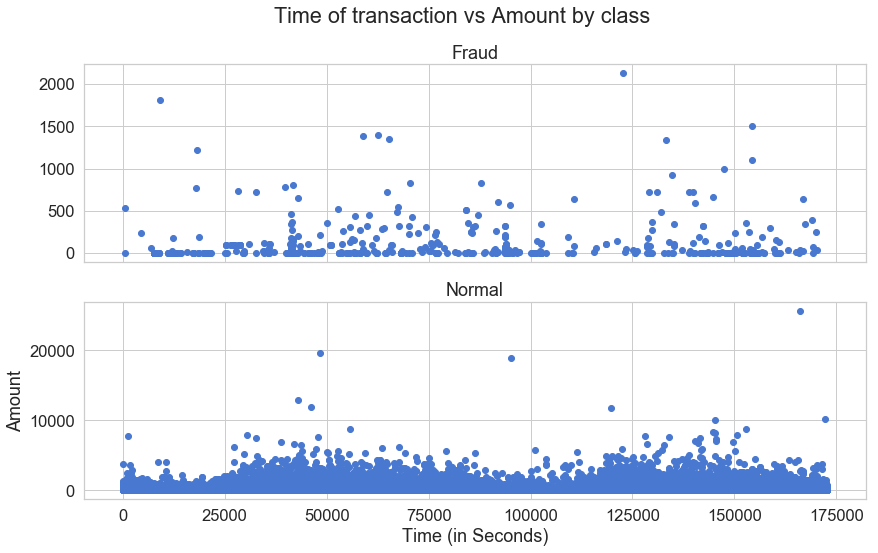

In [48]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

## Preparing the data

In [49]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [50]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,0


In [52]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [53]:
X_train.shape

(227451, 29)

In [102]:
input_dim = X_train.shape[1]
encoding_dim = 16

In [103]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim), activation="relu")(encoder)

decoder = Dense(int(encoding_dim), activation='relu')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [123]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                480       
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_24 (Dense)             (None, 29)                493       
Total params: 1,517
Trainable params: 1,517
Non-trainable params: 0
_________________________________________________________________


In [104]:
nb_epoch = 10
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="models/model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 22s 95us/step - loss: 0.7334 - acc: 0.6747 - val_loss: 0.7080 - val_acc: 0.7613
Epoch 2/10
227451/227451 [==============================] - 20s 88us/step - loss: 0.6591 - acc: 0.7860 - val_loss: 0.6859 - val_acc: 0.8011
Epoch 3/10
227451/227451 [==============================] - 19s 84us/step - loss: 0.6458 - acc: 0.8106 - val_loss: 0.6746 - val_acc: 0.8154
Epoch 4/10
227451/227451 [==============================] - 19s 83us/step - loss: 0.6352 - acc: 0.8304 - val_loss: 0.6649 - val_acc: 0.8435
Epoch 5/10
227451/227451 [==============================] - 19s 83us/step - loss: 0.6282 - acc: 0.8431 - val_loss: 0.6653 - val_acc: 0.8487
Epoch 6/10
227451/227451 [==============================] - 20s 90us/step - loss: 0.6261 - acc: 0.8495 - val_loss: 0.6628 - val_acc: 0.8553
Epoch 7/10
227451/227451 [==============================] - 19s 85us/step - loss: 0.6268 - acc: 0.8456 - val_

In [105]:
autoencoder = load_model('model.h5')

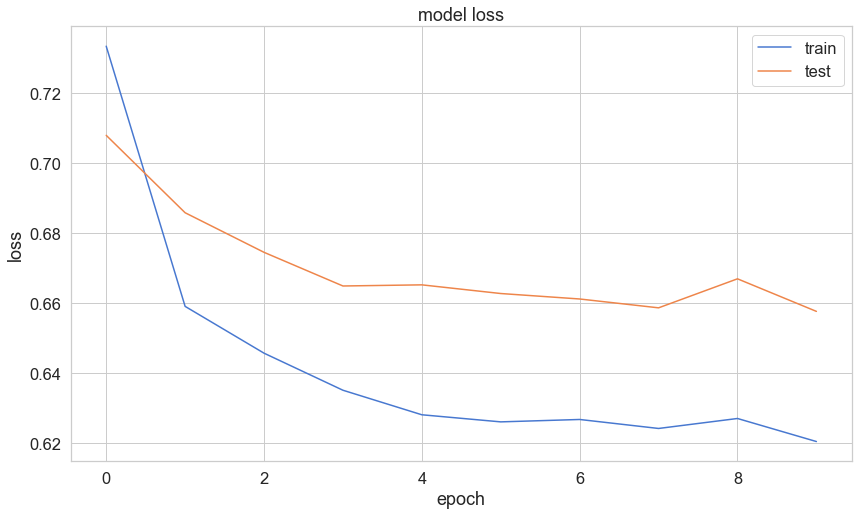

In [106]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [107]:
predictions = autoencoder.predict(X_test)

In [108]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [109]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.649955,0.001720
std,3.368778,0.041443
min,0.032788,0.000000
25%,0.202284,0.000000
50%,0.326751,0.000000
75%,0.528726,0.000000
max,307.799328,1.000000


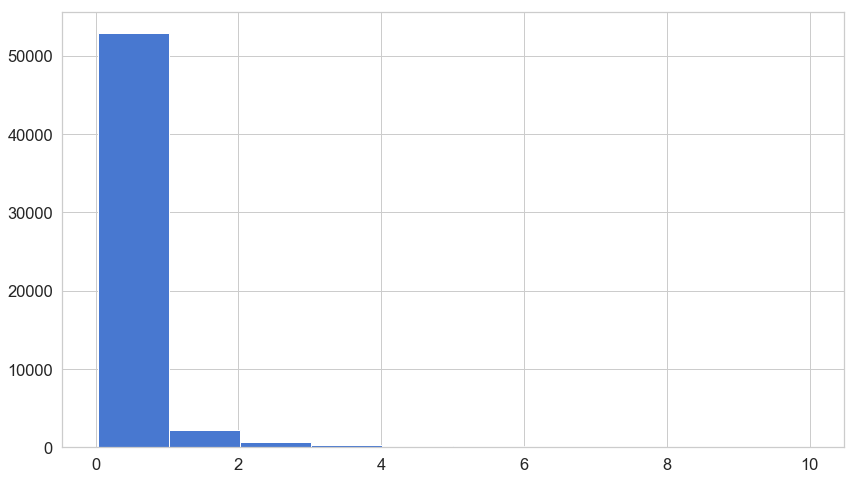

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

### Reconstruction error with fraud

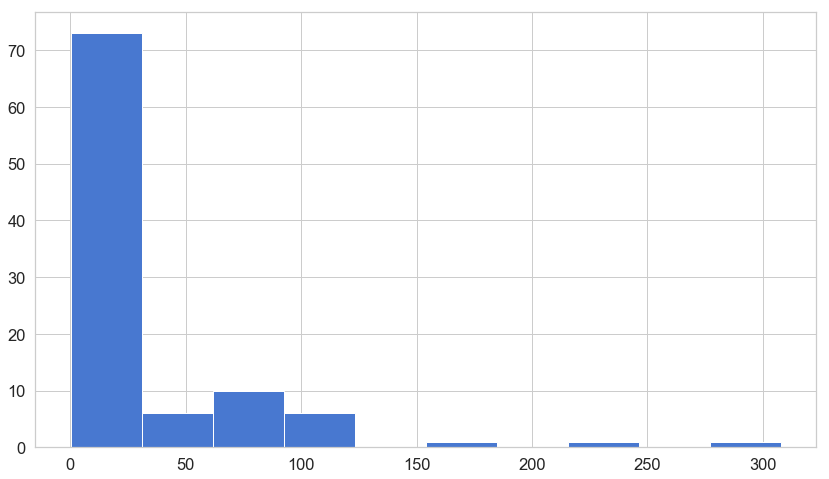

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [112]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

In [113]:
threshold = 50.0

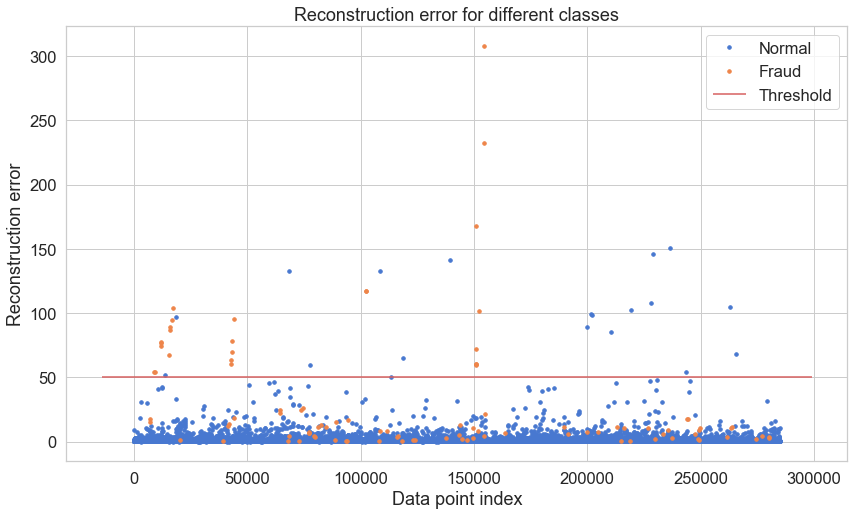

In [114]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

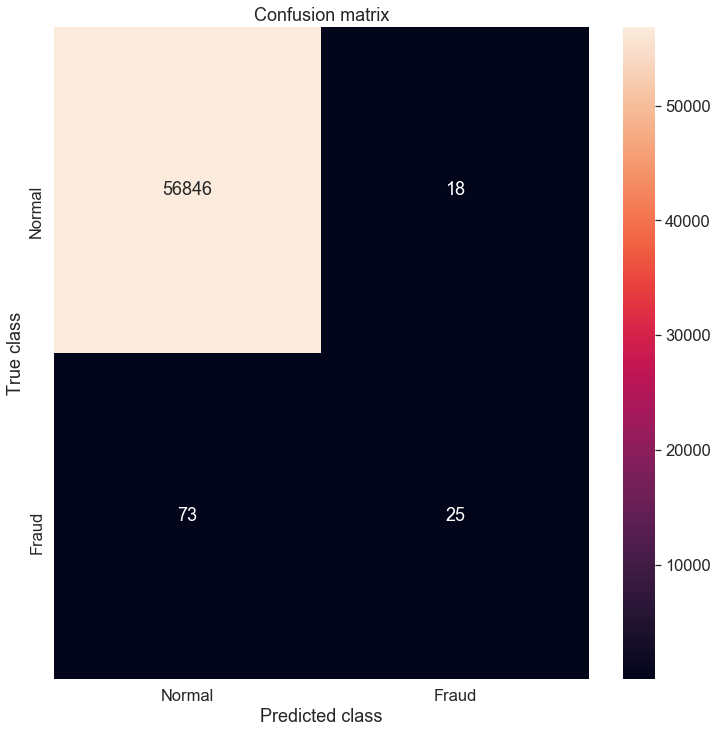

In [115]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [268]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
#     return z_mean + K.exp(0.5 * z_log_var) * epsilon
    return z_mean + K.exp(z_log_var) * epsilon

In [269]:
# # network parameters
# input_shape = (input_dim, )
# intermediate_dim = 24
# # latent_dim = 2
# latent_dim = 20

# # VAE model = encoder + decoder
# # build encoder model
# inputs = Input(shape=input_shape, name='encoder_input')
# x = Dense(intermediate_dim, activation='relu')(inputs)
# z_mean = Dense(latent_dim, name='z_mean')(x)
# z_log_var = Dense(latent_dim, name='z_log_var')(x)

# # use reparameterization trick to push the sampling out as input
# # note that "output_shape" isn't necessary with the TensorFlow backend
# z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# # instantiate encoder model
# encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
# encoder.summary()
# plot_model(encoder, to_file='models/vae_mlp_encoder.png', show_shapes=True)

# # build decoder model
# latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
# x = Dense(intermediate_dim, activation='relu')(latent_inputs)
# o = Dense(input_dim, activation='sigmoid')(x)

# # instantiate decoder model
# decoder = Model(inputs=latent_inputs, outputs=o, name='decoder_2')
# decoder.summary()
# plot_model(decoder, to_file='models/vae_mlp_decoder.png', show_shapes=True)

# # instantiate VAE model
# encoder_output=encoder(inputs)
# print(encoder_output)
# outputs = decoder(encoder_output[2])
# vae = Model(inputs, outputs, name='vae_mlp')

In [270]:
# network parameters
input_shape = (input_dim, )
intermediate_dim = 20
# latent_dim = 2
latent_dim = 16

# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# build decoder model
x = Dense(intermediate_dim, activation='relu')(z)
outputs = Dense(input_dim, activation='tanh')(x)

vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 29)           0                                            
__________________________________________________________________________________________________
dense_90 (Dense)                (None, 20)           600         encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           336         dense_90[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           336         dense_90[0][0]                   
__________________________________________________________________________________________________
z (Lambda)

In [271]:
reconstruction_loss = mse(inputs, outputs)
print("reconstruction_loss shape", reconstruction_loss.shape)
# reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
print("kl_loss shape", kl_loss.shape)
kl_loss = K.mean(kl_loss, axis=-1)
print("kl_loss shape", kl_loss.shape)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
print("vae_loss shape", vae_loss.shape)
vae.add_loss(vae_loss)
vae.compile(optimizer=optimizers.Adam(lr=0.001),metrics=["accuracy"])

reconstruction_loss shape (?,)
kl_loss shape (?, 16)
kl_loss shape (?,)
vae_loss shape ()


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel_launcher.py:12: UserWarning: Output "dense_92" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_92" during training.
  if sys.path[0] == '':


In [272]:
epochs = 30
batch_size = 64

history2 = vae.fit(X_train, epochs=epochs, 
                   batch_size=batch_size, 
                   shuffle=True,
                   verbose=1,
                   validation_data=(X_test, None)).history
# vae.save_weights('models/vae_mlp_mnist.h5')

Train on 227451 samples, validate on 56962 samples
Epoch 1/30
227451/227451 [==============================] - 30s 131us/step - loss: 439826559.8339 - val_loss: 0.9652
Epoch 2/30
227451/227451 [==============================] - 32s 140us/step - loss: 11.8244 - val_loss: 0.9159
Epoch 3/30
227451/227451 [==============================] - 30s 131us/step - loss: 0.8789 - val_loss: 0.8961
Epoch 4/30
227451/227451 [==============================] - 15s 64us/step - loss: 0.8658 - val_loss: 0.8861
Epoch 5/30
227451/227451 [==============================] - 12s 51us/step - loss: 0.8570 - val_loss: 0.8768
Epoch 6/30
227451/227451 [==============================] - 11s 48us/step - loss: 0.8484 - val_loss: 0.8714
Epoch 7/30
227451/227451 [==============================] - 11s 49us/step - loss: 0.8448 - val_loss: 0.8692
Epoch 8/30
227451/227451 [==============================] - 11s 50us/step - loss: 0.8425 - val_loss: 0.8675
Epoch 9/30
227451/227451 [==============================] - 12s 52us/step

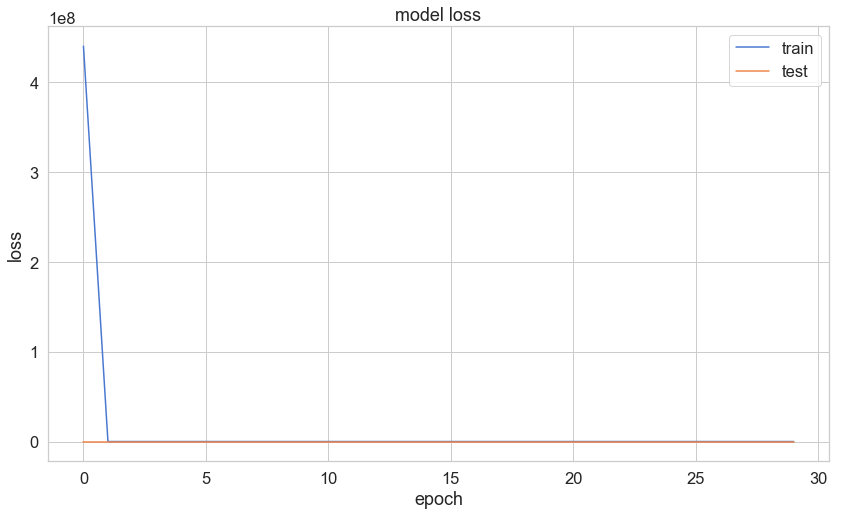

In [273]:
plt.plot(history2['loss'])
plt.plot(history2['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [274]:
predictions = vae.predict(X_test)

In [275]:
mse_ = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse_,
                        'true_class': y_test})

In [276]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.667551,0.001720
std,3.460230,0.041443
min,0.037367,0.000000
25%,0.192983,0.000000
50%,0.305862,0.000000
75%,0.507993,0.000000
max,254.086706,1.000000


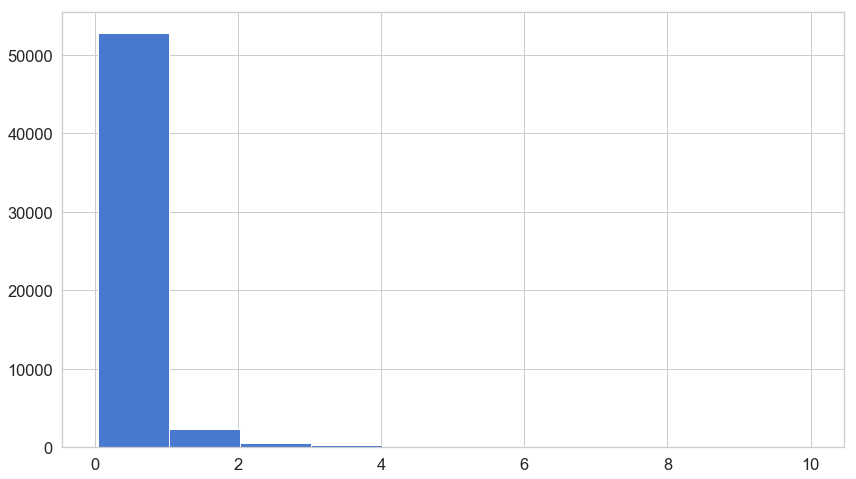

In [277]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

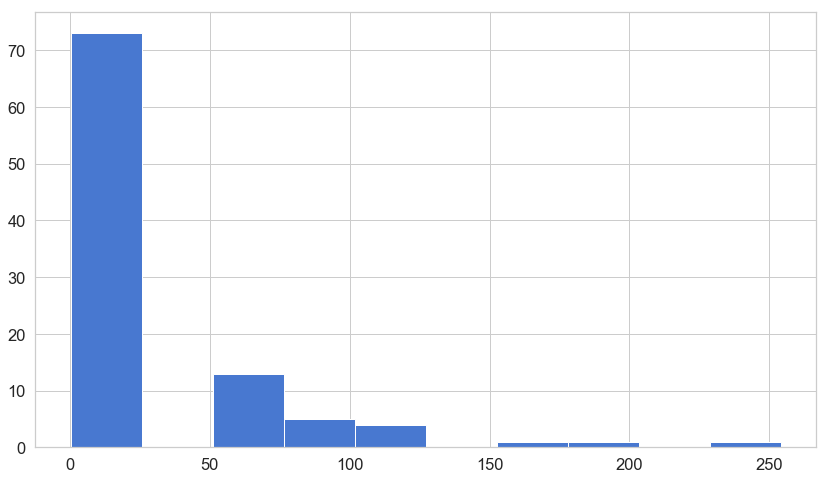

In [278]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

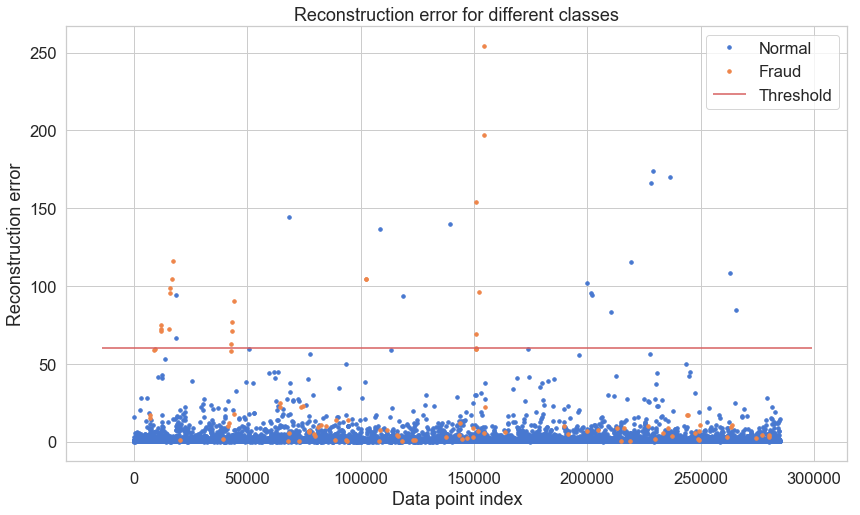

In [279]:
threshold = 60.0

groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

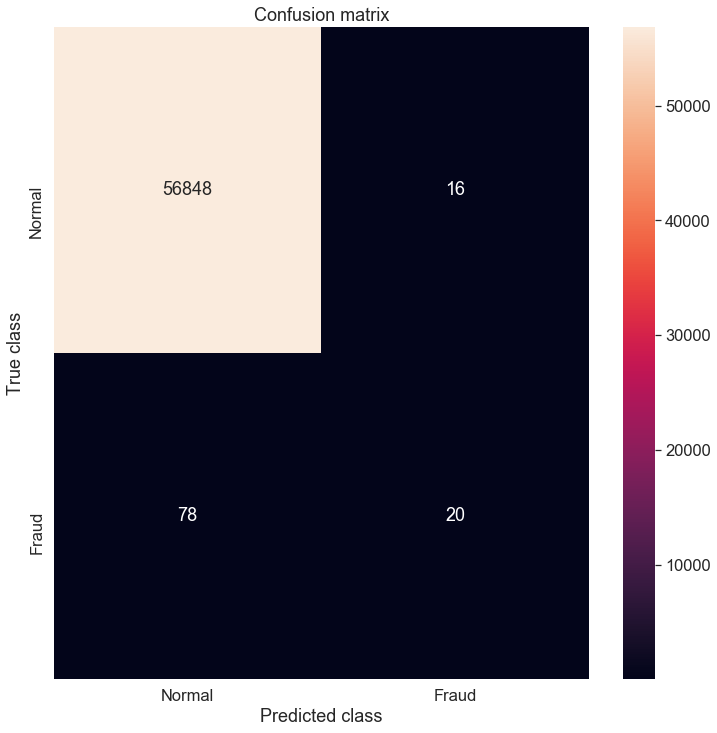

In [280]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()